## Task 2 - Prediction of store sales

### 2.1 Preprocessing

Import Libraries and Load Data

In [3]:
# Basic Imports
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

# Modeling Imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')


In [4]:
# Load the cleaned data
cleaned_data_df = pd.read_csv('cleaned_train_store_data.csv')

In [5]:
cleaned_data_df 

,Unnamed: 0,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Date,StateHoliday,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,SalePerCustomer
0,0,1,5,5263,555,1,1,1,2015-07-31,o,...,9.0,2008.0,0,0.0,0.0,0,2015,7,31,9.482883
1,1,2,5,6064,625,1,1,1,2015-07-31,o,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,9.702400
2,2,3,5,8314,821,1,1,1,2015-07-31,o,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,10.126675
3,3,4,5,13995,1498,1,1,1,2015-07-31,o,...,9.0,2009.0,0,0.0,0.0,0,2015,7,31,9.342457
4,4,5,5,4822,559,1,1,1,2015-07-31,o,...,4.0,2015.0,0,0.0,0.0,0,2015,7,31,8.626118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017150,1017150,1111,2,0,0,0,0,1,2013-01-01,a,...,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,NaN
1017151,1017151,1112,2,0,0,0,0,1,2013-01-01,a,...,4.0,2006.0,0,0.0,0.0,0,2013,1,1,NaN
1017152,1017152,1113,2,0,0,0,0,1,2013-01-01,a,...,0.0,0.0,0,0.0,0.0,0,2013,1,1,NaN
1017153,1017153,1114,2,0,0,0,0,1,2013-01-01,a,...,0.0,0.0,0,0.0,0.0,0,2013,1,1,NaN


In [6]:
# Convert 'Date' column to datetime
cleaned_data_df['Date'] = pd.to_datetime(cleaned_data_df['Date'])


In [7]:
# Extract the day of the week (0 = Monday, 6 = Sunday)
# This helps identify weekly patterns in sales, as customer behavior often varies by day of the week.
cleaned_data_df['DayOfWeek'] = cleaned_data_df['Date'].dt.dayofweek

# Create a binary feature indicating weekends (1 if weekend, 0 if not)
# Weekend sales may differ significantly from weekday sales, so this feature can help capture that variation.
cleaned_data_df['IsWeekend'] = cleaned_data_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Extract the day of the month (1 to 31)
# Sales trends may vary based on specific days in the month, such as the beginning or end, possibly due to salary dates or monthly budgeting.
cleaned_data_df['Day'] = cleaned_data_df['Date'].dt.day

# Extract the month (1 to 12)
# Monthly sales trends are common due to seasonality, holidays, or weather changes, which can impact customer behavior over specific months.
cleaned_data_df['Month'] = cleaned_data_df['Date'].dt.month

# Extract the quarter of the year (1 to 4)
# Sales patterns may change across quarters, often due to seasonal trends or fiscal quarters, impacting purchasing behavior.
cleaned_data_df['Quarter'] = cleaned_data_df['Date'].dt.quarter

In [8]:
cleaned_data_df[['Date', 'DayOfWeek', 'IsWeekend', 'Day', 'Month', 'Quarter']].head()

,Date,DayOfWeek,IsWeekend,Day,Month,Quarter
0,2015-07-31,4,0,31,7,3
1,2015-07-31,4,0,31,7,3
2,2015-07-31,4,0,31,7,3
3,2015-07-31,4,0,31,7,3
4,2015-07-31,4,0,31,7,3


In [9]:
 #Handle Categorical Variables
# Convert any remaining categorical variables to numerical format using one-hot encoding
cleaned_data_df = pd.get_dummies(cleaned_data_df, drop_first=True)

In [10]:
cleaned_data_df

,Unnamed: 0,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Date,StoreType,...,Day,SalePerCustomer,IsWeekend,Quarter,StateHoliday_b,StateHoliday_c,StateHoliday_o,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,0,1,4,5263,555,1,1,1,2015-07-31,2,...,31,9.482883,0,3,False,False,True,False,False,False
1,1,2,4,6064,625,1,1,1,2015-07-31,0,...,31,9.702400,0,3,False,False,True,False,True,False
2,2,3,4,8314,821,1,1,1,2015-07-31,0,...,31,10.126675,0,3,False,False,True,False,True,False
3,3,4,4,13995,1498,1,1,1,2015-07-31,2,...,31,9.342457,0,3,False,False,True,False,False,False
4,4,5,4,4822,559,1,1,1,2015-07-31,0,...,31,8.626118,0,3,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017150,1017150,1111,1,0,0,0,0,1,2013-01-01,0,...,1,NaN,0,1,False,False,False,False,True,False
1017151,1017151,1112,1,0,0,0,0,1,2013-01-01,2,...,1,NaN,0,1,False,False,False,False,False,False
1017152,1017152,1113,1,0,0,0,0,1,2013-01-01,0,...,1,NaN,0,1,False,False,False,False,False,False
1017153,1017153,1114,1,0,0,0,0,1,2013-01-01,0,...,1,NaN,0,1,False,False,False,False,False,False


## 2.2 Building models with sklearn pipelines

In [11]:
#Define Features and Target Variable
# Separate the target variable (Sales) from the features used for prediction
X = cleaned_data_df.drop(columns=['Sales', 'Date'])  # Drop 'Sales' and 'Date' columns from features
y = cleaned_data_df['Sales']  

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [13]:
X = preprocessor.fit_transform(X)

In [14]:
X.shape

(1017155, 27)

In [15]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((813724, 27), (203431, 27))

In [16]:
from sklearn.impute import SimpleImputer

In [17]:
# Impute missing values with the mean (or use median for robustness)
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)  # Apply the same imputer to the test set

In [18]:
from sklearn.preprocessing import StandardScaler
#Scale the Data
# Use StandardScaler to normalize the features, helping with models sensitive to feature scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test = scaler.transform(X_test)        # Transform the testing data using the same scaler

Create an Evaluate Function to give all metrics after model Training

In [19]:
from sklearn.linear_model import Lasso
# Import regression models
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed  # Import Parallel and delayed

In [20]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [20]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 827.5466
- Mean Absolute Error: 465.8421
- R2 Score: 0.9539
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 825.2951
- Mean Absolute Error: 464.6606
- R2 Score: 0.9537


Lasso
Model performance for Training set
- Root Mean Squared Error: 827.6070
- Mean Absolute Error: 464.8113
- R2 Score: 0.9539
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 825.3724
- Mean Absolute Error: 463.6153
- R2 Score: 0.9537


Ridge
Model performance for Training set
- Root Mean Squared Error: 827.5468
- Mean Absolute Error: 465.8329
- R2 Score: 0.9539
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 825.2947
- Mean Absolute Error: 464.6493
- R2 Score: 0.9537


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 657.8084
- Mean Absolute Error: 423.0580
- R2 Score: 0.

In [21]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
5,Random Forest Regressor,0.999945
4,Decision Tree,0.999817
6,XGBRegressor,0.998746
2,Ridge,0.953748
0,Linear Regression,0.953748
1,Lasso,0.953739
3,K-Neighbors Regressor,0.952355
7,AdaBoost Regressor,0.743276


In [21]:
y_pred = y_test_pred  # Get predictions from the current model

# Plot Actual vs. Predicted Sales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title(f"Actual vs Predicted Sales for {LinearRegression}")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlim([y_test.min(), y_test.max()])  # Set x-axis limits
plt.ylim([y_test.min(), y_test.max()])  # Set y-axis limits
plt.grid(True)  # Add grid for better readability
plt.show()

NameError: name 'y_test_pred' is not defined

In [23]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
925539,0,3530.187566,-3530.187566
468649,8264,8580.513729,-316.513729
49180,5151,5529.728757,-378.728757
850565,3817,4563.245582,-746.245582
237822,11198,10176.248526,1021.751474
...,...,...,...
931215,6043,7488.661794,-1445.661794
728429,3474,5229.273246,-1755.273246
466224,3777,4563.245582,-786.245582
532049,4229,5058.777921,-829.777921


2.4 Post Prediction analysis

1. Tree-Based Models Feature Importance
- Tree-based models like Random Forest, XGBoost, and CatBoost provide built-in feature importance. Here's how you can extract and visualize feature importance from these models.
a. Using Tree-Based Models for Feature Importance

a. Random Forest Feature Importance

In [24]:
from sklearn.ensemble import RandomForestRegressor
# Fit a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [25]:
# Get feature importance
importances = rf_model.feature_importances_

# Check if X_train is a DataFrame or a NumPy array
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns.tolist()  # Get feature names if X_train is a DataFrame
else:
    # If X_train is a NumPy array, define the feature names manually or use a default naming convention
    feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)



In [26]:
# Print feature importance
importance_df

,Feature,Importance
3,Feature 3,8.650922e-01
18,Feature 18,1.344018e-01
9,Feature 9,2.946637e-04
1,Feature 1,1.532493e-04
0,Feature 0,1.302733e-05
17,Feature 17,8.576279e-06
16,Feature 16,5.324717e-06
7,Feature 7,5.192351e-06
2,Feature 2,4.804583e-06
11,Feature 11,4.710661e-06


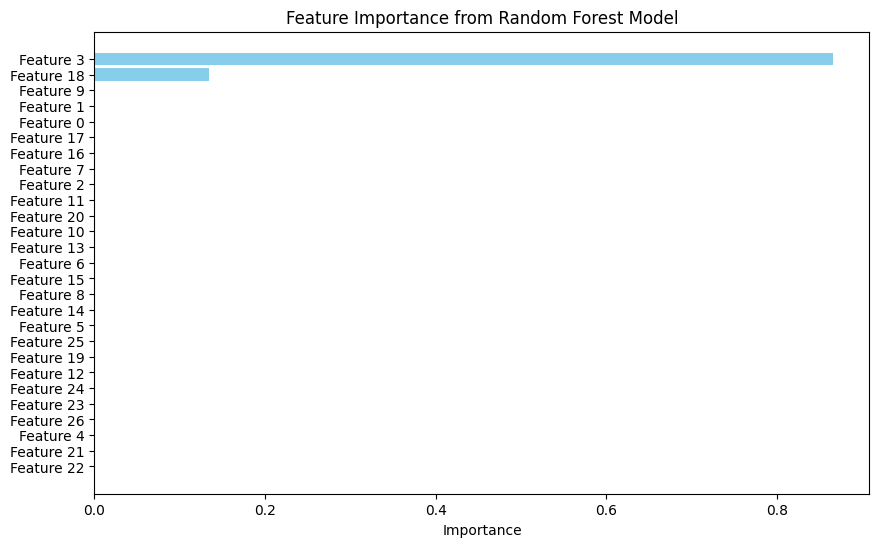

In [27]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()  
plt.show()

b. XGBoost Feature Importance

In [28]:
from xgboost import XGBRegressor

# Fit an XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

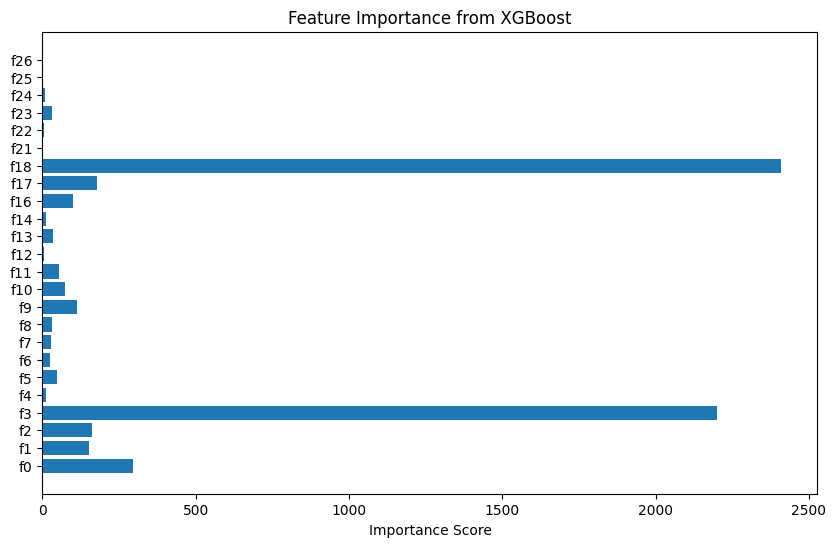

In [29]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(xgb_model.get_booster().get_score(importance_type='weight').keys(), xgb_model.get_booster().get_score(importance_type='weight').values())
plt.xlabel('Importance Score')
plt.title('Feature Importance from XGBoost')
plt.show()

Insights & Recommendations
Key Features: Features f21 and f4 are the strongest predictors of sales. Prioritize these in decision-making, especially if they represent controllable factors like promotions.
Low Impact Features: Features with minimal importance (e.g., f7, f8, f12) could be dropped to simplify the model.
Feature Optimization: Focus on refining the top features and consider feature engineering to capture more complex patterns if necessary.
Regular Updates: Retrain the model periodically to account for shifts in feature importance and ensure prediction accuracy.

c. Using Permutation Importance

In [22]:
from sklearn.inspection import permutation_importance

# Fit any model (e.g., Random Forest or any other)
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
# Compute permutation importance
results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

In [ ]:
# Create a DataFrame for the results
perm_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': results.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
# Plot permutation importance
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], color='lightgreen')
plt.xlabel('Importance Score')
plt.title('Permutation Feature Importance')
plt.show()

2.5 Serialize models

In [ ]:
import pickle
import datetime
#Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

#Generate a timestamp
timestamp = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
rf_pkl = f"random_forest_model_{timestamp}.pkl"

# Serialize the model
with open(rf_pkl, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f"Model saved as: {rf_pkl}")


In [ ]:
# Loading the model
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Use the loaded model for predictions
predictions = loaded_model.predict(X_test)